# Exact Optimization of Conformal Predictors via Incremental and Decremental Learning

This notebook documents (and allows to replicate) our experiments.
We define each nonconformity measure and its optimized version (whose name is denoted by `_fast`).
We then evaluate each of them for CP, and then compare the optimized ones with ICP.

# Imports and multiprocessing settings

In [1]:
# Disable multithreading in numpy for fair measurements.
# Needs to be run before importing numpy.
import os
import ctypes
def disable_np_multithreading():
    """A multithreading-disabling routine for numpy, taken
    from https://github.com/numpy/numpy/issues/11826.
    """
    try:
        import mkl
        mkl.set_num_threads(1)
        return 0
    except:
        pass 
    
    for name in [ "libmkl_rt.so", "libmkl_rt.dylib", "mkl_Rt.dll"]: 
        try: 
            mkl_rt = ctypes.CDLL(name)
            mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(1)))
            return 0 
        except:
            pass   

    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1" 
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [2]:
disable_np_multithreading()

import os
import json
import time
import copy
import bisect
import scipy
import doctest
import unittest
import functools
import matplotlib
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
from numpy.linalg import inv
from itertools import product
import matplotlib.pylab as plt
from sklearn.datasets import *
from interval import Interval as interval
from interval import Inf as inf
import matplotlib.ticker as ticker
from sklearn.utils import resample
from collections import defaultdict
from IPython.display import display
from parameterized import parameterized
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel

from eli import Eli

In [9]:
# Plots settings
DPI = 300
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
plt.style.use(['seaborn-white', 'seaborn-talk'])
matplotlib.rcParams['text.usetex'] = True #Let TeX do the typsetting
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
matplotlib.rcParams['font.family'] = 'sans-serif' # ... for regular text
matplotlib.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here


COLORS = ['#000000', '#174905', '#28836d', '#829bc5', '#d5c4dd']

# Definitions

In [81]:
def dist(a, b):
    return euclidean_distances([a], [b])[0][0]

## Nonconformity measures

A nonconformity measure (ncm)
$A((x, y); \{(x_1, y_1), ..., (x_{n}, y_{n})\}) \mapsto \mathcal{R}$
scores the conformity of an example $(x, y)$ with respect to a set
of training examples $\{(x_1, y_1), ..., (x_{n}, y_{n})\}$.
The larger its value is, the less conforming (~similar) the example
is to the training ones.

In this notebook, ncms should implement 2 methods:
- `train_ncm(X, Y)`
- `compute_scores(x, y, only_score_x)`

For simplicity, we define a common interface, `NCM`, which new
ncms can inherit from.

Simple (unoptimized) ncms can simply implement the method
`train_ncm(x, y, X, Y)`, and the remaining methods
(`train()` and `compute_scores()`) will be implemented automatically.

In [5]:
# Define an interface for nonconformity measures
class NCM:
    """A template for all nonconformity scorers.
    """
    def train(self, X, Y, inductive=False):
        """By default, this simply stores the training
        data as an element of the NCM object.
        """
        self.inductive = inductive
        if inductive:
            self.ncm = self.train_ncm(X, Y)
        else:
            self.X = np.array(X)
            self.Y = np.array(Y)

    def train_ncm(self, X, Y):
        """Should return the nonconformity scorer for
        the training data (X, Y), which is a function
        (x, y) -> score.
        """
        def example_scorer(x, y):
            raise NotImplemented
        
        return example_scorer

    def compute_scores(self, x, y, only_score_x=False):
        """Returns a tuple:
            (score_xy, scores)
        where score_xy is the score for (x, y) and
        scores are the nonconformity scores for the
        training examples.
        
        If `only_score_x = True`, this method returns
        only the prediction for (x, y), `score_xy`.
        """
        if self.inductive:
            ncm = self.ncm
        else:
            ncm = self.train_ncm(self.X, self.Y)
        
        score_x = ncm(x, y)
        
        if only_score_x:
            return score_x
        
        scores = []
        
        for i in range(len(self.X)):
            # Score the i-th example, removing it from the
            # training data and appending (x, y) instead
            idx = np.array(list(range(len(self.X))))
            if self.inductive:
                ncm = self.ncm
            else:
                ncm = self.train_ncm(np.row_stack((self.X[idx!=i,:], x)),
                                     np.append(self.Y[idx!=i], y))
            scores.append(ncm(self.X[i,:], self.Y[i]))
            
        return score_x, np.array(scores)

    def name(self):
        return self.__class__.__name__

### Simplified k-NN nonconformity measure

Particularly useful for anomaly detection contexts (where there is
just one label in training).


Fix a distance $d$. Let $\delta^j(x, X)$ be the $j$-th smallest
distance of $x$ from the elements of the set $X$.

$$A((x, y); \{(x_1, y_1), ..., (x_{n}, y_{n})\}) =
    \sum_{j=1}^k \delta^j(x, \{x_i \mid i=1...n, y_i=y\})$$

In [6]:
def best_k(a, k):
    if len(a) <= k:
        return a

    return a[np.argpartition(a, k)[:k]]

In [7]:
class SimplifiedKNN(NCM):
    def __init__(self, k=15):
        self.k = k

    def train_ncm(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        
        def scorer(x, y):
            dist = euclidean_distances([x], X[Y==y,:]).flatten()
            kdist = best_k(dist, self.k)
        
            return sum(kdist)
        
        return scorer

In [8]:
class SimplifiedKNN_fast(NCM):
    def __init__(self, k=15):
        self.k = k
    
    def train(self, X, Y):
        self.distances = {}
        self.temporary_scores = {}
        for y in set(Y):
            Xy = X[Y==y,:]
            if not len(Xy):
                raise Exception("[!] label `{}` not in training data".format(y))
            dist = euclidean_distances(Xy)
            # Only keep best k, excluding self (first column, because
            # distance will be 0).
            dist.sort(axis=1)
            dist = dist[:, 1:self.k+1]
            # Store.
            # NOTE: as a matter of fact, we could just keep 1 distance!
            self.distances[y] = dist
            self.temporary_scores[y] = np.sum(dist, axis=1)

        self.X = X
        self.Y = Y
    
    def compute_scores(self, x, y, only_score_x=False):
        if not self.distances:
            raise Exception("need to train the nonconformity measure first")
        
        # Score the new example first.
        distances_x = euclidean_distances([x], self.X[self.Y==y,:]).flatten()
        score_x = sum(best_k(distances_x, self.k))
        
        if only_score_x:
            return score_x

        # Compute the remaining scores.
        scores = []
        
        for yi in self.temporary_scores:
            if yi != y:
                # Scores not affected by (x, y).
                scores += list(self.temporary_scores[yi])
            else:
                #assert len(distances_x) == len(self.distances[yi])
                for dist_x, kdist, tmp_score in zip(distances_x,
                                                    self.distances[yi],
                                                    self.temporary_scores[yi]):
                    # If the distance to x is among the k best, add it to the
                    # score and remove the larger one.
                    if kdist[-1] > dist_x:
                        score = tmp_score - kdist[-1] + dist_x
                    else:
                        score = tmp_score
                    scores.append(score)
        
        return score_x, np.array(scores)

### k-NN nonconformity measure

Fix a distance $d$. Let $\delta^j(x, X)$ be the $j$-th smallest
distance of $x$ from the elements of the set $X$.

$$A((x, y); \{(x_1, y_1), ..., (x_{n}, y_{n})\}) =
    \frac{\sum_{j=1}^k \delta^j(x, \{x_i \mid i=1...n, y_i=y\})}
         {\sum_{j=1}^k \delta^j(x, \{x_i \mid i=1...n, y_i\neq y\})}$$

In [29]:
class KNN(NCM):
    def __init__(self, k=15):
        self.k = k

    def train_ncm(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        
        def scorer(x, y):
            dist = euclidean_distances([x], X).flatten()
        
            # k best for y and for not y
            kdist_y = best_k(dist[Y==y], self.k)
            kdist_not_y = best_k(dist[Y!=y], self.k)

            return sum(kdist_y) / max(sum(kdist_not_y), 0.1)
        
        return scorer

In [30]:
class KNN_fast(NCM):
    def __init__(self, k=15):
        self.k = k
    
    def train(self, X, Y):
        # k best distances from y and from not y for each training point.
        self.distances_y = []
        self.distances_not_y = []
        self.temporary_scores = []

        for x, y, all_dist in zip(X, Y, euclidean_distances(X)):
            # Keep smallest k distances (excluding "self").
            kdist_y = sorted(all_dist[Y==y])[1:self.k+1]
            kdist_not_y = sorted(all_dist[Y!=y])[:self.k]
            score = sum(kdist_y) / sum(kdist_not_y)
            
            self.distances_y.append(kdist_y)
            self.distances_not_y.append(kdist_not_y)
            self.temporary_scores.append(score)

        self.X = X
        self.Y = Y
    
    def compute_scores(self, x, y, only_score_x=False):
        # Score the new example first.
        distances_x = euclidean_distances([x], self.X).flatten()
        
        # Best k for y and not y.
        kdist_y = best_k(distances_x[self.Y==y], self.k)
        kdist_not_y = best_k(distances_x[self.Y!=y], self.k)
        
        score_x = sum(kdist_y) / max(sum(kdist_not_y), 0.1) 
        
        if only_score_x:
            return score_x

        # Compute the remaining scores.
        scores = []
        
        for dist_x, kdist_y, kdist_not_y, score, yi in zip(distances_x,
                                                           self.distances_y,
                                                           self.distances_not_y,
                                                           self.temporary_scores,
                                                           self.Y):
            if yi == y:
                # dist_x affects the score's nominator if its label
                # is yi, the denominator otherwise.
                if len(kdist_y) < self.k or kdist_y[-1] > dist_x:
                    # Remove effect of dist_y[-1] and use new distance.
                    # NOTE: write "kdist_y[:self.k-1]" and not "kdist_y[:-1]"
                    # or the code will have issues when dealing with small
                    # training sets (and train objects don't have k neighbors).
                    score = (score / sum(kdist_y)) * (sum(kdist_y[:self.k-1]) + dist_x)
            else:
                if len(kdist_not_y) < self.k or kdist_not_y[-1] > dist_x:
                    score = (score * sum(kdist_not_y)) / (sum(kdist_not_y[:self.k-1]) + dist_x)
            
            scores.append(score)
    
        return score_x, np.array(scores)

### 1-NN nonconformity measure

For some distance $d$:

$$A((x, y); \{(x_1, y_1), ..., (x_{n}, y_{n})\}) =
    \frac{min_{i=1, ..., n: y_i=y} d(x, x_i)}
         {min_{i=1, ..., n: y_i\neq y} d(x, x_i)}$$

**Note**

We instantiate the NN nonconformity measure, and conduct experiments with it.
However, since its results are almost identical to those of k-NN (and its
asymptotic complexity is the same), we did not include them in the paper.

In [31]:
class NN(KNN):
    def __init__(self):
        super().__init__(k=1)

In [32]:
class NN_fast(KNN_fast):
    def __init__(self):
        super().__init__(k=1)

### KDE

$$A((x, y); \{(x_1, y_1), ..., (x_{n}, y_{n})\}) =
  - \left(\frac{1}{n_yh^d} \sum_{x_i: y_i = y} K \left(\frac{x - x_i}{h}\right)\right)$$

where $n_y = |\{ i=1, ..., n : y_i = y \}|$, $K$ is a kernel, $h$ is the bandwidth.

We use minus the log-likelihood of the respective scores, for numerical stability of CP.

In [33]:
from sklearn.neighbors import KernelDensity

class KDE(NCM):
    def __init__(self, h=1.):
        self.h = h

    def train_ncm(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        kde = KernelDensity(bandwidth=self.h)
        
        def scorer(x, y):
            kde.fit(X[Y==y,:])

            # Uncomment for likelihood. We use -loglikelihood by default.
            #return -np.exp(kde.score([x]))
            return -kde.score([x])
        
        return scorer

In [34]:
class KDE_fast(NCM):
    def __init__(self, h=1.):
        self.h = h
    
    def train(self, X, Y):
        scores = {}
        mult_factor = {}

        for y in set(Y):
            Xy = X[Y==y, :]
            ny, d = Xy.shape
            dist_squared = euclidean_distances(Xy, squared=True)
            K = np.exp(-.5*dist_squared)
            # Remove contribution of distance to self.
            K -= np.eye(ny)
            # Precompute temporary scores and multiplicative factors.
            scores[y] = np.sum(K, axis=0)
            
            mult_factor[y] = -(2*np.pi)**(-.5*d)/((ny-1)*self.h**d)
        
        self.X = X
        self.Y = Y
        self.temporary_scores = scores
        self.mult_factor = mult_factor
        
    def compute_scores(self, x, y, only_score_x=False):
        # Preprocess kernel and compute score for (x, y).
        Xy = self.X[self.Y==y,:]
        dist_squared_y = euclidean_distances([x],
                                             Xy,
                                             squared=True).flatten()
        K = np.exp(-.5*dist_squared_y)
        
        # Update multiplicative factor.
        ny, d = Xy.shape
        mult_factor_y = self.mult_factor[y] * ((ny-1)*self.h**d)/(ny*self.h**d)
        
        # Compute the score for x.
        score_x = sum(K)*mult_factor_y
        
        if only_score_x:
            return score_x

        scores = []
        for yi, scores_yi in self.temporary_scores.items():
            if yi == y:
                # Update scores with example (x, y).
                scores_yi = scores_yi + K
                mult_factor = mult_factor_y
            else:
                mult_factor = self.mult_factor[yi]

            scores += list(scores_yi*mult_factor)
        
        # NOTE: can be further sped up by keeping track of the log-likelihood
        # instead of normal likelihood.
        return -np.log(-score_x), -np.log(-np.array(scores))

The `KDE_fast` alternative defined below (`KDE_fast_mpmath`) uses arbitrary precision math (via the `mpmath` module) to get exact solutions. This is used for cases where the inter-distances (see `dist_squared` in the code) take large values. It is slower than `KDE_fast`.

In [35]:
import mpmath

k = lambda x: mpmath.exp(-.5*x)
kernel = np.vectorize(k)

class KDE_fast_mpmath(NCM):
    def __init__(self, h=1.):
        self.h = h

    def train(self, X, Y):
        scores = {}
        mult_factor = {}

        for y in set(Y):
            Xy = X[Y==y, :]
            ny, d = Xy.shape
            # Not accounting for bandwidth here.
            dist_squared = euclidean_distances(Xy, squared=True)
            # Arbitrary precision. TODO: can be improved.
            K = kernel(dist_squared)
            # This would be better (computation-wise) but it's
            # unstable if dist_squared has large values:
            #K = np.exp(-.5*dist_squared)
            # Remove contribution of distance to self.
            K -= np.eye(ny)
            # Precompute temporary scores and multiplicative factors.
            scores[y] = np.sum(K, axis=0)
            mult_factor[y] = -(2*np.pi)**(-.5*d)/((ny-1)*self.h**d)

        self.X = X
        self.Y = Y
        self.temporary_scores = scores
        self.mult_factor = mult_factor
        
    def compute_scores(self, x, y, only_score_x=False):
        # Preprocess kernel and compute score for (x, y).
        Xy = self.X[self.Y==y,:]
        dist_squared_y = euclidean_distances([x],
                                             Xy,
                                             squared=True).flatten()
        #K = np.exp(-.5*dist_squared_y)
        K = kernel(dist_squared_y)
        
        # Update multiplicative factor.
        ny, d = Xy.shape
        mult_factor_y = self.mult_factor[y] * ((ny-1)*self.h**d)/(ny*self.h**d)
        
        # Compute the score for x.
        score_x = sum(K)*mult_factor_y
        
        if only_score_x:
            return score_x

        scores = []
        for yi, scores_yi in self.temporary_scores.items():
            if yi == y:
                # Update scores with example (x, y).
                scores_yi = scores_yi + K
                mult_factor = mult_factor_y
            else:
                mult_factor = self.mult_factor[yi]

            scores += list(scores_yi*mult_factor)
        
        # NOTE: can be further sped up by keeping track of the log-likelihood
        # instead of likelihood within the algorithm.

        # We convert from mpmath to ndarray when taking log.
        logf = np.vectorize(mpmath.log)
        return -logf([-score_x]).astype(float)[0], -logf(-np.array(scores)).astype(float)

### Least-squares SVM

$$w^* = \Phi[\Phi^T \Phi + \rho I_N]^{-1}y = [\rho I_J + \Phi\Phi^T]^{-1}\Phi y$$


We consider LS-SVM (ridge regression) as a classifier.
Predictions $y >= 0$ indicate label y=+1, predictions $y < 0$
mean label $y=-1$.

We define the nonconformity measure as follows:

$$A((x, y); \{(x_1, y_1), ..., (x_{n}, y_{n})\}) = -y f(x)$$

where $f(x)$ is the prediction of LS-SVM for $x$.

In [ ]:
def linear_kernel(A):
    return np.array(A).T

In [ ]:
class LSSVM(NCM):
    def __init__(self, feature_map=None, rho=1.):
        if not feature_map:
            # Linear kernel if map is not specified
            self.phi = linear_kernel
        else:
            self.phi = lambda A: np.atleast_2d(list(map(feature_map, A))).T
        self.rho = rho

    def train_ncm(self, X, Y):
        n = len(X)
        X = np.array(X)
        Y = np.atleast_2d(Y).T
        # Labels to {-1, 1}
        Y[Y==0] = -1
        assert len(np.unique(Y)) == 2
        
        Phi = self.phi(X)
        I = np.eye(n)
        w = Phi @ inv(Phi.T @ Phi + self.rho*I) @ Y
        
        def scorer(x, y):
            if y == 0:
                y = -1
            pred = (w.T @ self.phi([x])).item()

            return -pred*y
        
        return scorer

In [ ]:
class LSSVM_fast(NCM):
    def __init__(self, feature_map=None, rho=1.):
        if not feature_map:
            # Linear kernel if map is not specified
            self.phi = linear_kernel
        else:
            self.phi = lambda A: np.atleast_2d(list(map(feature_map, A))).T
        self.rho = rho
    
    def _add_example(self, x, y, w, C):
        """Increments the trained LSSVM weights `w` with
        a new example.
        """
        I = np.eye(len(C))
        phi_x = self.phi([x])
        update = (C-I) @ phi_x  @ (phi_x.T @ w - y)
        update /= (phi_x.T @ phi_x + self.rho - phi_x.T @ C @ phi_x).item()
        # NOTE: do not change to "w += update", otherwise
        # you'll be modifying the "w" provided as input :)
        w = w + update

        update = (C-I) @ phi_x @ phi_x.T @ (C-I)
        update /= (phi_x.T @ phi_x + self.rho - phi_x.T @ C @ phi_x).item()
        C = C + update
        
        return w, C
    
    def _remove_example(self, x, y, w, C, compute_c=True):
        """Decrements the trained LSSVM weights `w` after removing
        one examples.
        """
        I = np.eye(len(C))
        phi_x = self.phi([x])
        update = (C-I) @ phi_x  @ (phi_x.T @ w - y)
        update /= (-phi_x.T @ phi_x + self.rho + phi_x.T @ C @ phi_x).item()
        w = w - update
        
        if compute_c:
            update = (C-I) @ phi_x @ phi_x.T @ (C-I)
            update /= (-phi_x.T @ phi_x + self.rho + phi_x.T @ C @ phi_x).item()
            C = C - update
        else:
            C = None
        
        return w, C
    
    def _predict(self, x, w):
        return (w.T @ self.phi(x)).item()

    def train(self, X, Y):
        n = len(X)
        X = np.array(X)
        Y = np.atleast_2d(Y).T
        # Labels to {-1, 1}
        Y[Y==0] = -1
        assert set(np.unique(Y)) == set([-1, 1]), "Only binary labels in {-1, 1}!"
        
        # Prepare for incremental/decremental learning
        Phi = self.phi(X)
        I = np.eye(n)
        # NOTE: we could have made this even faster by computing
        # inv(Phi.T @ Phi + self.rho*I) only once, and by
        # rearranging the terms.
        self.w = Phi @ inv(Phi.T @ Phi + self.rho*I) @ Y
        self.C = Phi @ inv(Phi.T @ Phi + self.rho*I) @ Phi.T

        # Need to keep them for CP
        self.X = X
        self.Y = Y

    def compute_scores(self, x, y, only_score_x=False):
        # Labels to {-1, 1}
        if y == 0:
            y = -1
        
        w = self.w
        C = self.C

        # Score x for first
        score_x = -y * self._predict(x, w)
        
        if only_score_x:
            return score_x
        
        # Add x to training
        w, C = self._add_example(x, y, w, C)
        
        # Score all the rest
        scores = []
        for xi, yi in zip(self.X, self.Y):
            yi = yi.item()
            w_tmp, _ = self._remove_example(xi, yi, w, C, compute_c=False)
            score = -yi * self._predict(xi, w_tmp)
            scores.append(score)
        
        return score_x, np.array(scores)

### Random forest

Training: we generate many bootstrap samples $(X_b, Y_b)$ until there are B
for every training point $(x_i, y_i)$ and for a (placeholder) test point
$(x, y)$. A bootstrap sample is used for a point if that point does not
belong to the sample.
We also pre-train a model for each $(X_b, Y_b)$ if $(x, y) \notin (X_b, Y_b)$,
and pre-compute the score for all points $(x_i, y_i) \notin (X_b, Y_b)$.

Scoring: for each training example $(x_i, y_i)$ we train every model that hasn't
been trained already, and we use it to predict $(x_i, y_i)$, and average
the predictions.

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DT

class BaggingClassifier:
    def __init__(self, model, n_estimators=200, random_state=None,
                 **model_args):
        self.n_classes = None
        self.estimators_ = [None]*n_estimators
        self.model = model
        self.model_args = model_args
        self.random_state = random_state
        self.model_args["random_state"] = random_state
        # The following dictionary associates the index i of a training
        # data point to the tree(s) where that point was used.
        self.used_data = defaultdict(set)

    def refit_estimator(self, X, Y, estimator_idx):
        Xboot, Yboot, used_idx = resample(X, Y,
                                          list(range(len(X))),
                                          replace=True)

        model = self.model(**self.model_args)
        model.fit(Xboot, Yboot)
        self.estimators_[estimator_idx] = model

        # Keep track of index of used points for this estimator.
        for i in used_idx:
            self.used_data[i] |= set([estimator_idx])

    def fit(self, X, Y):
        if not self.n_classes:
            self.n_classes = len(np.unique(Y))

        np.random.seed(self.random_state)

        for model_idx in range(len(self.estimators_)):
            self.refit_estimator(X, Y, model_idx)    

    def predict_proba(self, X):
        preds = []
        for x in X:
            preds_x = np.zeros(self.n_classes)
            for tree in self.estimators_:
                y = tree.predict([x])
                preds_x[y] += 1
            preds.append(preds_x / len(self.estimators_))

        return np.array(preds)

In [ ]:
class RandomForest(NCM):
    def __init__(self, n_estimators=10, max_depth=10, max_features="auto",
                 random_state=None):
        self.rf_args = dict(n_estimators=n_estimators,
                            max_depth=max_depth,
                            max_features=max_features,
                            random_state=random_state)

    def train_ncm(self, X, Y):
        n = len(X)
        X = np.array(X)
        
        rf = BaggingClassifier(DT, **self.rf_args)
        rf.fit(X, Y)
        
        def scorer(x, y):
            return -rf.predict_proba([x])[0][y]
        
        return scorer

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DT


class RandomForest_fast(NCM):
    def __init__(self, n_estimators=10, max_depth=10, max_features="auto",
                 random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.max_features = max_features
    
    def _fit_model(self, X, Y, idx):
        """Fits base classifier on subset idx of
        data (X, Y).
        """
        idx = np.array(idx, dtype=int)

        model = DT(max_depth=self.max_depth,
                   max_features=self.max_features,
                  )
        model.fit(X[idx,:], Y[idx])
        
        return model

    def train(self, X, Y):
        if not self.random_state is None:
            np.random.seed(self.random_state)

        models = []
        # Structure: idx_to_model[i] = [model_idx_0, model_idx_1, ...]
        idx_to_model = defaultdict(list)

        # We create bootstraps (and models) until each data point
        # has at least B models.
        # NOTE: we assume we already know the test point (x, y),
        # to which we associate index 0. If this point appears in
        # one of the bootstrap samples, we simply store the dataset
        # (excluding (x, y) of course) instead of the model.
        # If it doesn't appear, we pre-train the model.
        B = self.n_estimators
        # Add (x, y) placeholder at position 0.
        nan_vec = np.full(X.shape[1], np.nan)
        X = np.row_stack(([nan_vec], X))
        Y = np.concatenate(([np.nan], Y))
        # How many models each data point has.
        bootstrap_count = {i: 0 for i in range(len(X))}
        all_have_enough = lambda count: sum(np.array(list(count)) >= B) == len(count)

        while not all_have_enough(bootstrap_count.values()):
            used_idx = resample(list(range(len(X))), replace=True)
            used_idx_unique = set(used_idx)
            
            if not 0 in used_idx_unique:
                # Normal case: the test point is not in this
                # bootstrap sample. We can already fit the model.
                model = self._fit_model(X, Y, used_idx)
            else:
                # The test point should be in the bootstrap sample.
                # Since we don't know it, we store the indeces
                # that allow to generate this bootstrap sample.
                model = used_idx

            models.append(model)
            
            # We use this new model to compute the scores
            # for the points that were not in this bootstrap
            # sample.
            for i in range(len(X)):
                if i in used_idx_unique:
                    continue
                bootstrap_count[i] += 1
                idx_to_model[i].append(len(models)-1)

        self.idx_to_model = idx_to_model
        self.models = models
        self.X = X
        self.Y = Y
        self.n_labels = len(set(Y)) - 1 # Count to exclude placeholder "np.nan"

    def _predict(self, model, x, y, X=None, Y=None):
        # model can be a model or a list of indeces on
        # which the model should be trained.
        if isinstance(model, list):
            if X is None or Y is None:
                raise Exception("Specify (X, Y) for model retraining!")
            X = X[model,:]
            Y = Y[model]
            model = self._fit_model(X, Y, model)

        return model.predict([x])[0] == y

    def compute_scores(self, x, y, only_score_x=False):
        # Replace placeholder with test point (x, y).
        X, Y = self.X, self.Y
        X[0,:] = x
        Y[0] = y

        # Prediction for (x, y)
        pred_y = 0.
        for model_idx in self.idx_to_model[0][:self.n_estimators]:
            pred_y += self._predict(self.models[model_idx], x, y)

        score_x = -pred_y/self.n_estimators
        
        if only_score_x:
            return score_x
        
        # Score all the rest
        scores = []
        for point_idx, models_idx in self.idx_to_model.items():
            if point_idx == 0:
                continue
            xi, yi = self.X[point_idx,:], self.Y[point_idx]
            # Compute prediction for (xi, yi) given all
            # the models trained on data excluding it.
            models_idx = models_idx[:self.n_estimators]
            pred_y = 0.
            for idx in models_idx:
                pred_y += self._predict(self.models[idx], xi, yi, X, Y)

            scores.append(-pred_y/self.n_estimators)
        
        return score_x, np.array(scores)

## Conformal Prediction

In [ ]:
def compute_pvalues(x, labels, ncm, precomputed_scores=None):
    """Generic function for computing p-values for `x`
    for all candidate `labels` given a nonconformity
    measure `ncm`.
    If `precomputed_scores=None` this is used for (transductive) CP;
    otherwise for inductive CP.
    """
    pvalues_x = []
    for y in labels:
        if precomputed_scores is None:
            # CP
            score_x, scores = ncm.compute_scores(x, y)
        else:
            # ICP
            score_x = ncm.compute_scores(x, y, only_score_x=True)
            scores = precomputed_scores

        pvalue = (1 + sum(scores >= score_x)) / (1 + len(scores))
        pvalues_x.append(pvalue)

    return pvalues_x

**NOTE** We define two (equivalent) functions for doing CP:
a sequential version, which also returns running time information,
and a parallel one, designed for when we're only interested
in the predictions and not in the computational performance.

In [ ]:
def cp_predict(Xtrain, Ytrain, Xtest, labels, ncm,
               return_time=False, timeout=None):
    # Train nonconformity measure
    start = time.perf_counter()
    ncm.train(Xtrain, Ytrain)
    train_time = time.perf_counter() - start

    # Predict p-values
    start = time.perf_counter()
    prediction_times = []
    reached_timeout = False

    pvalues = []
    for x in Xtest:
        pvalues_x = compute_pvalues(x, labels, ncm)
        pvalues.append(pvalues_x)
        
        # Store time
        t = time.perf_counter() - start
        prediction_times.append(t)
        
        # Check if reached timeout
        if timeout and t > timeout:
            reached_timeout = True
            break
    
    if return_time:
        return np.array(pvalues), {"training_time": train_time,
                                   "prediction_time": prediction_times,
                                   "reached_timeout": reached_timeout,
                                   }
    else:
        return np.array(pvalues)

In [ ]:
def cp_predict_parallel(Xtrain, Ytrain, Xtest, labels, ncm, jobs=None):
    Xtrain = np.array(Xtrain)
    Ytrain = np.array(Ytrain)
    Xtest = np.array(Xtest)

    # Train nonconformity measure
    ncm.train(Xtrain, Ytrain)

    # Predict p-values
    with multiprocessing.Pool(jobs) as p:
        pvalues = p.map(functools.partial(compute_pvalues,
                                          labels=labels,
                                          ncm=ncm), Xtest)

    return np.array(pvalues)

ICP implementation.

In [ ]:
def icp_predict(Xtrain, Ytrain, Xcalib, Ycalib, Xtest,
                labels, ncm, return_time=False, timeout=None):
    # Train nonconformity measure
    start = time.perf_counter()
    ncm.train(Xtrain, Ytrain, inductive=True)
    train_time = time.perf_counter() - start
    
    # Calibrate
    start = time.perf_counter()
    scores = []
    for x, y in zip(Xcalib, Ycalib):
        scores.append(ncm.compute_scores(x, y, only_score_x=True))
    scores = np.array(scores)
    calibration_time = time.perf_counter() - start

    # Predict p-values
    start = time.perf_counter()
    prediction_times = []
    reached_timeout = False

    pvalues = []
    for x in Xtest:
        pvalues_x = compute_pvalues(x, labels, ncm, scores)
        pvalues.append(pvalues_x)
        
        # Store time
        t = time.perf_counter() - start
        prediction_times.append(t)
        
        # Check if reached timeout
        if timeout and t > timeout:
            reached_timeout = True
            break
    
    pred_time = time.perf_counter() - start
    
    if return_time:
        return np.array(pvalues), {"training_time": train_time,
                                   "calibration_time": calibration_time,
                                   "prediction_time": prediction_times,
                                   "reached_timeout": reached_timeout,
                                   }
    else:
        return np.array(pvalues)

# Correctness

Unit tests, to ensure the correctness of our implementations
(as much as it is possible).

## Unit test for CP

In [ ]:
class CPTests(unittest.TestCase):
    def setUp(self):
        self.X = [[0, 0], [1, 0], [0, 1], [1, 1], [1, 2]]
        self.Y = np.array([0, 0, 0, 1, 1])
        self.x = [2, 2]

    def test_cp(self):
        """Test 1-NN CP on hand-calculated values.
        """
        # Calculate with alternative method (manual)
        X = [[0, 0], [1, 0], [0, 1], [1, 1], [1, 2]]
        Y = np.array([0, 0, 0, 1, 1])
        x = [2, 2]
        
        X.append(self.x)
        D = euclidean_distances(X)
        # Scores given y = 0
        score_x = D[1,5]/D[4,5]
        scores = np.array([D[1,0]/D[3,0], D[0,1]/D[3,1], D[0,2]/D[3,2], D[4,3]/D[4,3], D[3,4]/D[5,4]])
        pvalue0 = (sum(scores >= score_x)+1) / (len(scores)+1)
        # Scores given y = 1
        score_x = D[4,5]/D[1,5]
        scores = np.array([D[1,0]/D[3,0], D[0,1]/D[3,1], D[0,2]/D[3,2], D[4,3]/D[4,3], D[3,4]/D[2,4]])
        pvalue1 = (sum(scores >= score_x)+1) / (len(scores)+1)
        
        expected_pvalues = [pvalue0, pvalue1]
        
        output = cp_predict(self.X, self.Y, [self.x, self.x], [0, 1], ncm=NN())
        output = list(output[0,:])

        self.assertListEqual(output, expected_pvalues)

    def test_icp_cp(self):
        """ICP with Xtrain=Xcalib and Ytrain=Ycalib must be equivalent to CP.
        
        Evaluation numbers come from test_cp_scores().
        """
        # Calculate with alternative method (manual)
        Xtrain = [[0, 0], [1, 0], [0, 1], [1, 1], [1, 2]]
        Ytrain = np.array([0, 0, 0, 1, 1])
        Xcalib = [[4, 3], [1, -1], [2, 1], [4, 5]]
        Ycalib = [0, 0, 1, 1]
        x = [2, 2]
        
        # Calibration scores
        D = euclidean_distances(Xcalib, Xtrain)
        scores = np.array([D[0,1]/D[0,4], D[1,1]/D[1,3], D[2,3]/D[2,1], D[3,4]/D[3,2]])

        # Scores given y = 0
        D = euclidean_distances([x], Xtrain).flatten()
        score_x = D[1]/D[4]
        pvalue0 = (sum(scores >= score_x)+1) / (len(scores)+1)

        # Scores given y = 1
        D = euclidean_distances([x], Xtrain).flatten()
        score_x = D[4]/D[1]
        pvalue1 = (sum(scores >= score_x)+1) / (len(scores)+1)
        
        expected_pvalues = [pvalue0, pvalue1]
        
        output = icp_predict(Xtrain, Ytrain, Xcalib, Ycalib, [x, x], [0, 1], ncm=NN())
        output = list(output[0,:])

        self.assertListEqual(output, expected_pvalues)

    def test_cp_parallel_equivalent(self):
        """CP and parallel CP should give the same results.
        """
        X, Y = load_iris(return_X_y=True)

        r1 = cp_predict(X, Y, X, np.unique(Y), KNN_fast())
        r2 = cp_predict_parallel(X, Y, X, np.unique(Y), KNN_fast())

        np.testing.assert_allclose(r1, r2)

## Verify that optimized NCMs are equivalent to unoptimized ones

In [ ]:
class NCMTests(unittest.TestCase):
    
    def setUp(self):       
        X, Y = load_iris(return_X_y=True)
        Y[Y==2] = 1
        
        np.random.seed(0)
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest = train_test_split(X, Y, test_size=50)
    
    @parameterized.expand([
        [NN(), NN_fast()],
        [SimplifiedKNN(), SimplifiedKNN_fast()],
        [KNN(), KNN_fast()],
        [KDE(), KDE_fast()],
        [LSSVM(), LSSVM_fast()],
        # NOTE: random forest is not an exact approximation.
        [RandomForest(random_state=0), RandomForest_fast(random_state=0), 0.2],
    ])
    def test_equivalent(self, ncm_a, ncm_b, rtol=1e-07):
        """Are standard and optimized ncms equivalent?
        """
        print(f"Testing: {ncm_a.__class__.__name__}, {ncm_b.__class__.__name__}")
        ncm_a.train(self.Xtrain, self.Ytrain)
        ncm_b.train(self.Xtrain, self.Ytrain)
        
        for x, y in zip(self.Xtest, self.Ytest):
            score_x_a, scores_a = ncm_a.compute_scores(x, y)
            score_x_b, scores_b = ncm_b.compute_scores(x, y)
            np.testing.assert_allclose(score_x_a, score_x_b, rtol=rtol)
            # NOTE: we sort the scores here, because for some ncms
            # (e.g., SimplifiedKNN) the fast version returns the
            # same scores in a different order. Of course, for the
            # CP algorithm the order of the scores is irrelevant.
            np.testing.assert_allclose(sorted(scores_a),
                                       sorted(scores_b), rtol=rtol)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(NCMTests)
_ = unittest.TextTestRunner().run(suite)

# Computational performance

Predictions scale linearly in the number of test
points (times the expense of computing the prediction for one).

Therefore, it's interesting to evaluate how changing the
size of the training data affects the performance.
We  measure the time to predict 100 test points,
and then will be concerned in the average time this takes.

We select the number of training points from the set
`np.logspace(1, 5, 13, dtype='int').tolist()`.

For these experiments the kind of data is not
important: we only care about the running time.
We therefore generate data by using `scikit-learn`'s
`make_classification()`.

## Note on the experiments (Eli)

To run our experiments, we use a simple library we wrote, `Eli`,
which enables launching jobs over several parameters, and
fetching the respective results, via a simple interface.

For example, suppose we want to launch function `foo(a, b)`
for values `a = 0, 1, ..., 9` and fixed `b=5`.
The output of the function must be a `dict` containing its
results (e.g., `{"res": a+b}`).

```python
eli = Eli("results/")

eli.run_experiment(exp_name="experiment-foo",
                   func=foo,                      # Function to launch
                   repetitions=5,                 # Repetitions per parameter combination
                   n_jobs=40,                     # Number of concurrent processes
                   automatic_seed=True,           # Automatically change numpy seed for each repetition
                   # Parameters (appearance order matters!)
                   a=list(range(10)),
                   b=5,
                  )
```

Results will be found in `results/experiment-foo`, and they can be fetched with:

```python
results = eli.fetch_results("experiment-foo")
```

## Experiment 

In [ ]:
def evaluate_ncm(ncm, train_size, max_test_size, n_classes, n_dimensions,
                 inductive_cp, calibration_size, timeout):
    # Discard invalid parameter sets.
    if inductive_cp and calibration_size is None:
        return
    if not inductive_cp and calibration_size is not None:
        return
    
    ncm_class = eval(ncm)       # eval(): Perdoname, madre, por mi vida loca :D
    ncm = ncm_class()

    X, Y = make_classification(train_size+max_test_size,
                               n_dimensions, n_classes=n_classes)

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=max_test_size)

    if inductive_cp:
        Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtrain, Ytrain,
                                                          test_size=calibration_size)
        _, times = icp_predict(Xtrain, Ytrain, Xcalib, Ycalib,
                               Xtest, np.unique(Y), ncm, return_time=True)
    else:
        _, times = cp_predict(Xtrain, Ytrain, Xtest, np.unique(Y),
                          ncm, return_time=True, timeout=timeout)
    
    return times

In [4]:
EXPERIMENT_NAME = "training-size-comparison"
RESULTS_DIR = "results/"
REPETITIONS = 5
TRAIN_SIZE = np.logspace(1, 5, 13, dtype='int').tolist()
MAX_TEST_SIZE = 100
N_CLASSES = 2
N_DIMENSIONS = 30
TIMEOUT = 60*60*10

### CP vs optimized CP

We run the experiments for training size $n \in [10, 10^5]$, with two exceptions:

- Standard LS-SVM only runs up to 4641.
- Standard and optimized Random Forest only run up to 46415.

For larger values of $n$, the training time of the above methods (LS-SVM and Random Forest)
would go well beyond the timeout time that we fixed for the plots (Figure 1 in paper).

In [ ]:
# All nonconformity measures except for the above exceptions

NCMs = ["NN", "SimplifiedKNN", "KNN", "KDE"]
NCMs += [ncm + "_fast" for ncm in NCMs]
NCMs += ["LSSVM_fast"]

eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm=NCMs,
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   inductive_cp=False,
                   calibration_size=None,
                   timeout=TIMEOUT,
                  )

In [ ]:
eli = Eli(RESULTS_DIR)

# LS-SVM
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm="LSSVM",
                   train_size=TRAIN_SIZE[:9],
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   inductive_cp=False,
                   calibration_size=None,
                   timeout=TIMEOUT,
                  )

# Random Forest
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm=["RandomForest", "RandomForest_fast"],
                   train_size=TRAIN_SIZE[:12],
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   inductive_cp=False,
                   calibration_size=None,
                   timeout=TIMEOUT,
                  )

### ICP

For ICP we run all the methods together, with $n \in [10, 10^5]$.

In [ ]:
NCMs = ["NN", "SimplifiedKNN", "KNN", "KDE", "LSSVM", "RandomForest"]

eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                   n_jobs=40,
                   automatic_seed=True,
                   # Parameters
                   ncm=NCMs,
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   inductive_cp=True,
                   calibration_size=0.5,
                   timeout=TIMEOUT,
                  )

## Plots and results

Comparing with respect to the training size.

In [6]:
# Load data

eli = Eli(RESULTS_DIR)
results = eli.fetch_results("training-size-comparison")

print(f"{len(results)} observations")

NAMES = {"SimplifiedKNN": "Simplified k-NN",
         "KNN": "k-NN",
         "LSSVM": "LS-SVM",
         "KDE": "KDE",
         "RandomForest": "Random Forest",
        }
TIMEOUT = 60*60*10

avgerage_time = lambda vec: np.concatenate((
                                [vec[0]],
                                pd.Series(vec).diff()[1:]
                            )).mean()

results["avg_time"] = results.prediction_time.apply(avgerage_time)

results.head()

1200 observations


,name,training_time,calibration_time,prediction_time,reached_timeout,ncm,train_size,max_test_size,n_classes,n_dimensions,inductive_cp,calibration_size,timeout,repetition,git-commit,started,finished,avg_time
0,ncm=RandomForest-train_size=4641-max_test_size...,0.108136,1.312082,"[0.009590358007699251, 0.023431785870343447, 0...",False,RandomForest,4641,100,2,30,True,0.5,36000,0,88c0ef46a4fdee12a2715739adff119d7cd24953,2021-04-12T15:06:45.735397+00:00,2021-04-12T15:06:48.068019+00:00,0.008963
1,ncm=RandomForest-train_size=4641-max_test_size...,0.103274,1.319600,"[0.008455939823761582, 0.01775519293732941, 0....",False,RandomForest,4641,100,2,30,True,0.5,36000,3,88c0ef46a4fdee12a2715739adff119d7cd24953,2021-04-12T15:06:52.704668+00:00,2021-04-12T15:06:55.035293+00:00,0.008912
2,ncm=RandomForest-train_size=4641-max_test_size...,0.108236,1.270121,"[0.008516540052369237, 0.01738778594881296, 0....",False,RandomForest,4641,100,2,30,True,0.5,36000,4,88c0ef46a4fdee12a2715739adff119d7cd24953,2021-04-12T15:06:55.062958+00:00,2021-04-12T15:06:57.322627+00:00,0.008649
3,ncm=RandomForest-train_size=4641-max_test_size...,0.099264,1.261298,"[0.008587141055613756, 0.01721918396651745, 0....",False,RandomForest,4641,100,2,30,True,0.5,36000,2,88c0ef46a4fdee12a2715739adff119d7cd24953,2021-04-12T15:06:50.438903+00:00,2021-04-12T15:06:52.676796+00:00,0.008620
4,ncm=RandomForest-train_size=4641-max_test_size...,0.102344,1.314754,"[0.008790143998339772, 0.017412087181583047, 0...",False,RandomForest,4641,100,2,30,True,0.5,36000,1,88c0ef46a4fdee12a2715739adff119d7cd24953,2021-04-12T15:06:48.093314+00:00,2021-04-12T15:06:50.410478+00:00,0.008850


In the following cell, we calculate the numbers reported in the paper.

In [61]:
print("k-NN optimized avg pred (100k): {} seconds".format(
            results[(results.ncm=="KNN_fast") &
                    (results.train_size==100000) &
                    (results.inductive_cp==False)].avg_time.mean()))
print("k-NN avg pred (100k): {} hours".format(
            results[(results.ncm=="KNN") &
                    (results.train_size==100000) &
                    (results.inductive_cp==False)].avg_time.mean()/60/60))

print("LSSVM optimized avg pred (4641): {} seconds".format(
            results[(results.ncm=="LSSVM_fast") &
                    (results.train_size==4641) &
                    (results.inductive_cp==False)].avg_time.mean()))
print("LSSVM avg pred (4641): {} hours".format(
            results[(results.ncm=="LSSVM") &
                    (results.train_size==4641) &
                    (results.inductive_cp==False)].avg_time.mean()/60/60))

print("RF optimized avg pred (46415): {} hours".format(
            results[(results.ncm=="RandomForest_fast") &
                    (results.inductive_cp==False) &
                    (results.train_size==46415)].avg_time.mean()/60/60))
print("RF avg pred (46415): {} hours".format(
            results[(results.ncm=="RandomForest") &
                    (results.inductive_cp==False) &
                    (results.train_size==46415)].avg_time.mean()/60/60))

print("k-NN (train: 100k test: 20k): {} h training {} h prediction".format(
            results[(results.ncm=="KNN_fast") &
                    (results.inductive_cp==False) &
                    (results.train_size==100000)].training_time.mean()/60/60,
            results[(results.ncm=="KNN_fast") &
                    (results.inductive_cp==False) &
                    (results.train_size==100000)].avg_time.mean()*20000/60/60))
print("k-NN (train: 100k test: 20k): {} h training {} years prediction".format(
            0,
            results[(results.ncm=="KNN") &
                    (results.inductive_cp==False) &
                    (results.train_size==100000)].avg_time.mean()*20000/60/60/24/365))

print("LSSVM optimized avg pred (100k): {} seconds".format(
            results[(results.ncm=="LSSVM_fast") &
                    (results.train_size==100000) &
                    (results.inductive_cp==False)].avg_time.mean()))
print("LSSVM ICP avg pred (100k): {} seconds".format(
            results[(results.ncm=="LSSVM") &
                    (results.train_size==100000) &
                    (results.inductive_cp==True)].avg_time.mean()))
print("KDE ICP avg pred (100k): {} seconds".format(
            results[(results.ncm=="KDE") &
                    (results.train_size==100000) &
                    (results.inductive_cp==True)].avg_time.mean()))
print("KDE optimized avg pred (100k): {} seconds".format(
            results[(results.ncm=="KDE_fast") &
                    (results.train_size==100000) &
                    (results.inductive_cp==False)].avg_time.mean()))

k-NN optimized avg pred (100k): 0.6334899960040057 seconds
k-NN avg pred (100k): 1.968957308143136 hours
LSSVM optimized avg pred (4641): 0.21028654634393754 seconds
LSSVM avg pred (4641): 24.52378716933872 hours
RF optimized avg pred (46415): 43.19851039095787 hours
RF avg pred (46415): 81.54313994453346 hours
k-NN (train: 100k test: 20k): 2.088605384212111 h training 3.5193888666889204 h prediction
k-NN (train: 100k test: 20k): 0 h training 4.495336319961498 years prediction
LSSVM optimized avg pred (100k): 6.6777872765858195 seconds
LSSVM ICP avg pred (100k): 0.15608686965843663 seconds
KDE ICP avg pred (100k): 0.3133951543457806 seconds
KDE optimized avg pred (100k): 0.4642496941339923 seconds


Producing **Figure 1**.

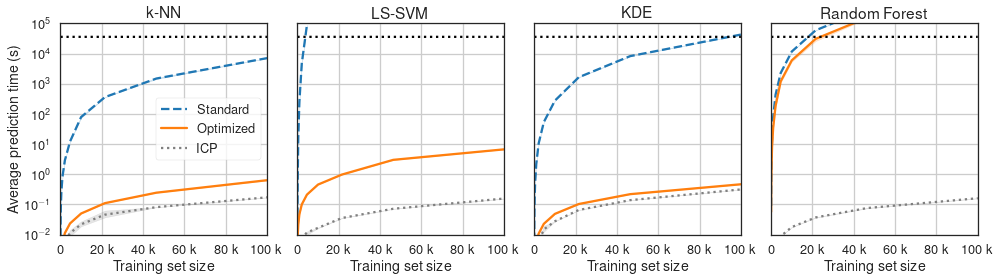

In [12]:
fig, axes = plt.subplots(1, 4, sharex=True,
                         figsize=(14, 4))
colors = sns.color_palette()
NCMS = ["KNN", "LSSVM", "KDE", "RandomForest"]

for i, (ax, ncm) in enumerate(zip(axes.flat, NCMS)):
    # CP
    plot_data = results[((results.ncm == ncm) | (results.ncm == ncm + "_fast")) &
                        (results.inductive_cp == False)]

    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm==ncm],
                 ax=ax, legend=None, label="Standard CP",
                 color=colors[0])
    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm==ncm+"_fast"],
                 ax=ax, legend=None, label="Optimized CP",
                 color=colors[1])
    
    # ICP
    plot_data_icp = results[(results.ncm == ncm) &
                        (results.inductive_cp == True) &
                        (results.calibration_size == 0.5)]
    
    sns.lineplot(x="train_size", y="avg_time", data=plot_data_icp,
                 ax=ax, legend=False, label="ICP",
                 color=colors[-3])

    ax.plot(range(10**5), [TIMEOUT]*10**5, color='k', ls=':')
    
    ax.lines[0].set_linestyle("--")
    ax.lines[2].set_linestyle(":")

    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.grid()
    ax.set_xlim([0, 10**5])
    ax.set_ylim([10**-2, 10**5])
    ax.set_title(NAMES[ncm])
    ax.set_xlabel("Training set size")
    ax.set_ylabel("Average prediction time (s)")
    if i == 0:
        ax.set_ylabel("Average prediction time (s)")
        ax.legend(title="", loc="best", frameon=True, labels=["Standard", "Optimized", "ICP"])
    else:
        ax.set_ylabel(None)
        plt.setp(ax.get_yticklabels(), visible=False)


plt.tight_layout()
plt.savefig(f"training-size-comparison-all.pdf", dpi=DPI)

Producing **Figure 5**.

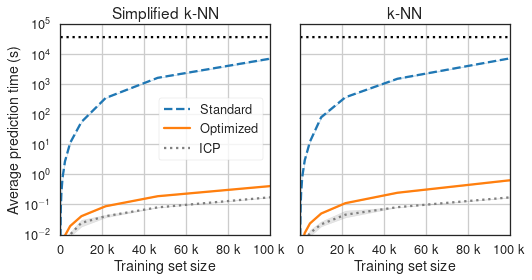

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True,
                         figsize=(7.5, 4))
colors = sns.color_palette()
NCMS = ["SimplifiedKNN", "KNN"]

for i, (ax, ncm) in enumerate(zip(axes.flat, NCMS)):
    plot_data = results[((results.ncm == ncm) | (results.ncm == ncm + "_fast")) &
                        (results.inductive_cp == False)]

    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm==ncm],
                 ax=ax, legend=None, label="Standard CP",
                 color=colors[0])
    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm==ncm+"_fast"],
                 ax=ax, legend=None, label="Optimized CP",
                 color=colors[1])
    
    # ICP
    plot_data = results[(results.ncm == ncm) &
                        (results.inductive_cp == True) &
                        (results.calibration_size == 0.5)]

    sns.lineplot(x="train_size", y="avg_time", data=plot_data,
                 ax=ax, legend=False, label="ICP",
                 color=colors[-3])

    ax.lines[0].set_linestyle("--")
    ax.lines[2].set_linestyle(":")

    ax.plot(range(10**5), [TIMEOUT]*10**5, color='k', ls=':')
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.grid()
    ax.set_xlim([0, 10**5])
    ax.set_ylim([10**-2, 10**5])
    ax.set_title(NAMES[ncm])
    ax.set_xlabel("Training set size")
    if i == 0:
        ax.set_ylabel("Average prediction time (s)")
        ax.legend(title="", loc="best", frameon=True, labels=["Standard", "Optimized", "ICP"])
    else:
        ax.set_ylabel(None)
        plt.setp(ax.get_yticklabels(), visible=False)

plt.tight_layout()
plt.savefig(f"training-size-comparison-fullknn-all.pdf", dpi=DPI)

# Training time of optimized CP

We measure the training time of optimized nonconformity measures separately.
This is used to produce **Figure 2**.

## Experiment

In [ ]:
def timeit(foo, *args, **kwargs):
    start = time.perf_counter()
    res = foo(*args, **kwargs)
    return time.perf_counter() - start, res

def measure_training_time(ncm, n):
    ncm = eval(ncm)()
    X, Y = make_classification(n, 30, n_classes=2)

    time, _ = timeit(ncm.train, X, Y)

    return {"training-time": time}

NCM_BASE = ["NN", "SimplifiedKNN", "KNN", "RandomForest", "KDE", "LSSVM"]
NCM_FAST = [f"{ncm}_fast" for ncm in NCM_BASE]
TRAIN_SIZE = np.logspace(1, 5, 13, dtype='int').tolist()

eli = Eli(RESULTS_DIR)

eli.run_experiment(exp_name="training-time",
                   func=measure_training_time,
                   repetitions=5,
                   n_jobs=1,
                   automatic_seed=True,
                   ncm=NCM_FAST,
                   n=TRAIN_SIZE,
                  )

## Plots

In [13]:
eli = Eli(RESULTS_DIR)
results = eli.fetch_results("training-time")
results.head()

,name,training-time,ncm,n,repetition,git-commit,started,finished
0,ncm=KDE_fast-n=10,0.000688,KDE_fast,10,0,429857c00ab0d3e8f1cdc09eba4fffc1c3f36348,2020-06-01T18:39:01.514476+00:00,2020-06-01T18:39:01.516808+00:00
1,ncm=KDE_fast-n=10,0.000634,KDE_fast,10,3,429857c00ab0d3e8f1cdc09eba4fffc1c3f36348,2020-06-01T18:39:01.592893+00:00,2020-06-01T18:39:01.594844+00:00
2,ncm=KDE_fast-n=10,0.000637,KDE_fast,10,4,429857c00ab0d3e8f1cdc09eba4fffc1c3f36348,2020-06-01T18:39:01.613110+00:00,2020-06-01T18:39:01.615095+00:00
3,ncm=KDE_fast-n=10,0.000624,KDE_fast,10,2,429857c00ab0d3e8f1cdc09eba4fffc1c3f36348,2020-06-01T18:39:01.569596+00:00,2020-06-01T18:39:01.571471+00:00
4,ncm=KDE_fast-n=10,0.000733,KDE_fast,10,1,429857c00ab0d3e8f1cdc09eba4fffc1c3f36348,2020-06-01T18:39:01.541619+00:00,2020-06-01T18:39:01.543809+00:00


Producing **Figure 2**.

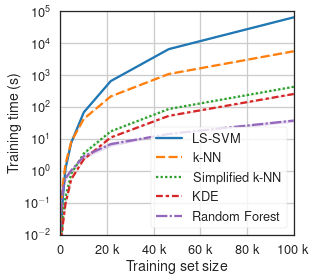

In [14]:
NAMES = {"SimplifiedKNN": "Simplified k-NN",
         "KNN": "k-NN",
         "LSSVM": "LS-SVM",
         "KDE": "KDE",
         "RandomForest": "Random Forest",
        }
NCM_SORTED = ["LSSVM", "KNN", "SimplifiedKNN", "KDE", "RandomForest"]

fig, ax = plt.subplots(figsize=(4.5, 4))

plot_data = results

# Sort labels
plot_data.ncm = [ncm.replace("_fast", "") for ncm in plot_data.ncm]
plot_data.ncm = pd.Categorical(plot_data.ncm, NCM_SORTED)
plot_data = plot_data.sort_values("ncm")

# Replace with nice names
plot_data.ncm = plot_data.ncm.apply(lambda ncm: NAMES[ncm])

g = sns.lineplot(x="n", y="training-time", data=plot_data,
             hue="ncm", style="ncm", ax=ax)

# Remove legend title.
g.legend_.set_title(None)
g.legend_.set_frame_on(True)

ax.set_yscale("log")
ax.set_xlim([0, 10**5])
ax.set_ylim([10**-2, 10**5])
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_xlabel("Training set size")
ax.set_ylabel("Training time (s)")
ax.grid()

fig.tight_layout()

plt.savefig("training-time.pdf", dpi=DPI)

# Multiprocessing comparison

We measure whether it's best to use multiprocessing or not, both
with CP and ICP, with optimized and unoptimized nonconformity measures.

## Experiments

In [ ]:
def generic1000():
    X, Y = make_classification(1000, 30, n_classes=2)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
    
    return Xtrain, Ytrain, Xtest, Ytest, "classification"

def generic100000():
    X, Y = make_classification(100000, 30, n_classes=2)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
    
    return Xtrain, Ytrain, Xtest, Ytest, "classification"

LOAD_DATASET = dict(
    generic1000=generic1000,
    generic100000=generic100000,
)


def timeit(foo, *args, **kwargs):
    start = time.perf_counter()
    foo(*args, **kwargs)
    return time.perf_counter() - start

def cp_classification(ncm, dataset, parallel=False):
    # Load NCM.
    ncm_class = eval(ncm)       # eval: Perdoname, madre, por mi vida loca :D
    ncm = ncm_class()

    # Load data.
    Xtrain, Ytrain, Xtest, Ytest, task = LOAD_DATASET[dataset]()
    if task == "classification":
        labels = set(Ytrain) | set(Ytest)
    else:
        raise Exception(f"Task {task} undefined.")

    func = cp_predict_parallel if parallel else cp_predict
    pvalues = func(Xtrain, Ytrain, Xtest, labels, ncm=ncm)


def time_methods(ncm, dataset):
    return {"CP": timeit(cp_classification, ncm, dataset, parallel=False),
            "CP Parallel": timeit(cp_classification, ncm, dataset, parallel=True),
           }

In [ ]:
NCMs = ["NN", "LSSVM", "SimplifiedKNN", "KNN", "KDE", "RandomForest"]
NCMs += [x + "_fast" for x in NCMs]

eli = Eli(RESULTS_DIR)

# First run for all with a dataset of 1k examples
eli.run_experiment(exp_name="to-parallel-or-not",
                   func=time_methods,
                   repetitions=1,
                   n_jobs=1,
                   automatic_seed=True,
                   # Parameters
                   dataset="generic1000",
                   ncm=NCMs,
                  )

# Run just for optimized k-NN for a dataset of 100k examples
eli.run_experiment(exp_name="to-parallel-or-not",
                   func=time_methods,
                   repetitions=1,
                   n_jobs=1,
                   automatic_seed=True,
                   # Parameters
                   dataset="generic100000",
                   ncm="KNN_fast",
                  )

## Plots

In [15]:
eli = Eli(RESULTS_DIR)
results = eli.fetch_results("to-parallel-or-not")

results.head()

,name,CP,CP Parallel,ICP,ICP Parallel,dataset,ncm,repetition,git-commit,started,finished
0,dataset=generic500-ncm=KNN,15.836166,0.951336,0.235575,0.527536,generic500,KNN,0,adbfbe95d569eec31a71f654d35af9279216b4df,2020-05-27T14:54:25.325975+00:00,2020-05-27T14:54:42.876824+00:00
1,dataset=generic500-ncm=KNN,15.370247,0.955251,0.241041,0.563496,generic500,KNN,3,adbfbe95d569eec31a71f654d35af9279216b4df,2020-05-27T14:55:18.907586+00:00,2020-05-27T14:55:36.037856+00:00
2,dataset=generic500-ncm=KNN,15.411377,0.943102,0.235843,0.521436,generic500,KNN,4,adbfbe95d569eec31a71f654d35af9279216b4df,2020-05-27T14:55:36.066316+00:00,2020-05-27T14:55:53.178292+00:00
3,dataset=generic500-ncm=KNN,17.060600,0.954220,0.238130,0.544712,generic500,KNN,2,adbfbe95d569eec31a71f654d35af9279216b4df,2020-05-27T14:55:00.081821+00:00,2020-05-27T14:55:18.880108+00:00
4,dataset=generic500-ncm=KNN,15.231931,1.062567,0.277911,0.576440,generic500,KNN,1,adbfbe95d569eec31a71f654d35af9279216b4df,2020-05-27T14:54:42.906576+00:00,2020-05-27T14:55:00.055732+00:00


In [51]:
def highlight_min(data, color='yellow'):
    '''
    highlight the minimum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)


NCMs = ["NN", "SimplifiedKNN", "KNN", "KDE", "LSSVM", "RandomForest"]
NCMs = NCMs + [f"{ncm}_fast" for ncm in NCMs]

for dataset in ["generic1000", "generic100000"]:
    # Prepare data
    print(dataset)
    table_results = results[results.dataset==dataset]

    table_results = {
        "CP": table_results.groupby("ncm")["CP"].mean(),
        "CP-std": table_results.groupby("ncm")["CP"].std(),
        "CP Parallel": table_results.groupby("ncm")["CP Parallel"].mean(),
        "CP Parallel-std": table_results.groupby("ncm")["CP Parallel"].std(),
    }
    table_results = pd.DataFrame(table_results)
    table_results.index = pd.Categorical(table_results.index, NCMs)
    table_results = table_results.sort_index()

    # Nice table on jupyter
    table = table_results[["CP", "CP Parallel"]]
    table.index.name = "NCM"
    display(table.style.apply(highlight_min,
                      color='darkorange',
                      axis=1, subset=["CP", "CP Parallel"]
                     ))

generic1000


,CP,CP Parallel
NCM,,
NN,75.038471,4.041478
SimplifiedKNN,74.595183,3.945033
KNN,82.144661,4.110659
KDE,138.483183,6.661167
LSSVM,8852.179454,624.744138
RandomForest,5061.670597,225.752851
NN_fast,1.404174,1.466071
SimplifiedKNN_fast,1.294473,0.432346
KNN_fast,1.604430,9.041655


generic100000


,CP,CP Parallel
NCM,,
KNN_fast,12742.034330,3918.190429


# k-NN CP regression

Fix a distance $d$. Let $y_{(j)}$ be the label of the $j$-th closest
object ($x_{(j)}$) to example $(x, y)$.

$$A((x, y); \{(x_1, y_1), ..., (x_{n}, y_{n})\}) =
    |y-\frac{1}{k}\sum_{j=1}^k y_{(j)}|,$$
    
where the term $\frac{1}{k}\sum_{j=1}^k y_{(j)}$ is the k-NN regressor's prediction for $y$.

## Base implementations

### Full CP

In [ ]:
class KNNR_CP:
    def __init__(self, k):
        self.k = k

    def train(self, Xtrain, Ytrain):
        self.Xtrain = Xtrain
        self.Ytrain = Ytrain

    def compute_sets(self, x):
        # First compute a and b for (x, y).
        dist = euclidean_distances([x], self.Xtrain).flatten()
        best_idx = best_k_idx(dist, self.k)
        a_x = -sum(self.Ytrain[best_idx]) / len(best_idx)
        b_x = 1

        # Compute the remaining a and b, and construct P and S.
        P = []
        S = []
        for i, (xi, yi) in enumerate(zip(self.Xtrain, self.Ytrain)):
            idx = np.array(list(range(len(self.Xtrain))))
            dist = euclidean_distances([xi], np.row_stack(([x], self.Xtrain[idx!=i,:]))).flatten()
            Ytmp = np.concatenate(([0], self.Ytrain[idx!=i]))
            best_idx = best_k_idx(dist, self.k)
            # If (x, y) is one of the k-NNs.
            w = 1./self.k
            ai = yi - w*sum(Ytmp[best_idx])
            if 0 in best_idx:
                bi = -w
            else:
                bi = 0
            
            s, P = self._compute_set(ai, bi, a_x, b_x, P)
            S.append(s)
            
        
        return P, S
    
    def _compute_set(self, ai, bi, a_x, b_x, P):
        if bi < 0:
            ai = -ai
            bi = -bi

        if b_x > bi:
            p1 = -(ai-a_x)/(bi-b_x)
            p2 = -(ai+a_x)/(bi+b_x)
            if p1 == p2:
                s = {"type": "point",
                     #"points": interval([p1, p1]),
                     "j": (len(P)),
                    }
                P += [p1]
            else:
                s = {"type": "interval",
                     #"points": interval([p1, p2]),
                     "j": (len(P), len(P)+1),
                    }
                P += [p1, p2]
        elif b_x < bi:
            p1 = -(ai-a_x)/(bi-b_x)
            p2 = -(ai+a_x)/(bi+b_x)
            s = {"type": "union",
                 #"points": interval([-np.inf, p1], [p2, np.inf]),
                 "j": (len(P), len(P)+1),
                }
            P += [p1, p2]
            counter += 2
        elif a_x < ai:
            p = -(ai+a_x)/(2*bi)
            {"type": "right-ray",
             #"points": interval([p, np.inf]),
             "j": len(P),
            }
            P.append(p)
        elif a_x > ai:
            p = -(ai+a_x)/(2*bi)
            s = {"type": "left-ray",
                 #"points": interval([-np.inf, p]),
                 "j": len(P),
                }
            P.append(p)
        elif abs(a_x) <= abs(ai):
            s = {"type": "line",
                 #"points": interval([-np.inf, np.inf]),
                }
        elif abs(a_x) > abs(ai):
            s = {"type": "empty",
                 #"points": None,
                }
        else:
            raise Exception("Unhandled! Shouldn't happen.")
        
        return s, P
    
    def predict(self, x, epsilon):
        P, S = self.compute_sets(x)
        # Sort P, and create a dict to map to associate
        # points in the sets S[i] to points in (sorted) P.
        P, K = zip(*sorted(zip(P, range(len(P)))))
        # Note: the range() is shifted by 1 because we need
        # to add -infinity to the beginning of P.
        S_to_P = dict(zip(K, range(1, len(P)+1)))
        
        P = [-np.infty] + list(P) + [np.infty]
        m = len(P) - 2
        N = np.zeros(m+1)
        M = np.zeros(m)
        
        for i in range(len(self.Xtrain)):
            if S[i]["type"] == "empty":
                pass
            elif S[i]["type"] == "point":
                j = S[i]["j"]
                j = S_to_P[j]
                M[j-1] +=1
            elif S[i]["type"] == "interval":
                j1, j2 = S[i]["j"]
                j1, j2 = S_to_P[j1], S_to_P[j2]
                j1, j2 = (j1, j2) if j1 < j2 else (j2, j1)
                M[j1-1:j2] += 1
                N[j1:j2] += 1
            elif S[i]["type"] == "right-ray":
                j = S[i]["j"]
                j = S_to_P[j]
                M[j-1:] += 1
                N[j:] += 1
            elif S[i]["type"] == "left-ray":
                j = S[i]["j"]
                j = S_to_P[j]
                M[j-1:] += 1
                N[j:] += 1
            elif S[i]["type"] == "union":
                j1, j2 = S[i]["j"]
                j1, j2 = S_to_P[j1], S_to_P[j2]
                j1, j2 = (j1, j2) if j1 < j2 else (j2, j1)
                M[:j1-1] += 1
                M[j2-1:] += 1
                N[:j1-1] += 1
                N[j2:] += 1
            elif S[i]["type"] == "line":
                M += 1
                N += 1
            else:
                raise Exception("Unhandled! Shouldn't happen.")

        # Union of intervals.
        ints = []
        for j in range(len(N)):
            if (N[j] / (len(self.Xtrain)+1.)) > epsilon:
                ints.append([P[j], P[j+1]])
        
        # Exact solution:
        #for j in range(len(M)):
        #    if (M[j] / (len(self.Xtrain)+1.)) > epsilon:
        #        ints.append([P[j], P[j]])

        pred = interval(*ints)

        return pred

### Full CP Optimized

In [ ]:
def chunked_euclidean_distances(X, working_memory=2**14):
    for chunk in pairwise_distances_chunked(X, working_memory=working_memory):
        for dist in chunk:
            yield dist

In [ ]:
class KNNR_CP_fast(KNNR_CP):
    def __init__(self, k):
        self.k = k

    def train(self, Xtrain, Ytrain):
        self.Xtrain = Xtrain
        self.Ytrain = Ytrain
        
        # Precomputations.
        A = []
        D = []
        Y_max = []
        
        all_dists = chunked_euclidean_distances(Xtrain)

        for i, (dist, yi) in enumerate(zip(all_dists, Ytrain)):
            dist = np.delete(dist, i)
            Ytmp = np.delete(Ytrain, i)
            best_idx = best_k_idx(dist, self.k)

            # These "ai" don't account for the contribution of the test example.
            w = 1./self.k
            ai = yi - w*sum(Ytmp[best_idx])
            A.append(ai)

            # Keep track of largest distance (and label), in preparation for updates.
            idx = np.argmax(dist[best_idx])
            D.append(dist[best_idx][idx])
            Y_max.append(Ytmp[best_idx][idx])

        
        self.A = A
        self.D = D
        self.Y_max = Y_max

    def compute_sets(self, x):
        # First compute a and b for (x, y).
        dist = euclidean_distances([x], self.Xtrain).flatten()
        best_idx = best_k_idx(dist, self.k)
        a_x = -sum(self.Ytrain[best_idx]) / len(best_idx)
        b_x = 1
        w = 1./self.k

        # Update the remaining a and b, and construct P.
        P = []
        S = []
        for d_x, ai, di, y_max in zip(dist, self.A, self.D, self.Y_max):
            # Check if (x, y) is one of the k-NNs.
            if d_x < di:
                # Remove contribution of y_max (which isn't a k-NN anymore).
                # NOTE: as per algorithm, there's no need to add the contribution of y to ai.
                ai += w*y_max
                # Update bi.
                bi = -w
            else:
                bi = 0
            
            if bi < 0:
                ai = -ai
                bi = -bi
            
            s, P = self._compute_set(ai, bi, a_x, b_x, P)
            S.append(s)
        
        return P, S

### Unit tests for regression

In [ ]:
class KNNRTests(unittest.TestCase):
    
    def setUp(self):    
        np.random.seed(0)
        X, Y = make_regression (200)
        
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest = train_test_split(X, Y, test_size=100)
    
    @parameterized.expand([
        [KNNR_CP(5), KNNR_CP_fast(5)],
    ])
    def test_equivalent(self, cp_a, cp_b, rtol=1e-07):
        """Are standard and optimized ncms equivalent?
        """
        print(f"Testing: {cp_a.__class__.__name__}, {cp_b.__class__.__name__}")
        
        eps = 0.1
        
        cp_a.train(self.Xtrain, self.Ytrain)
        cp_b.train(self.Xtrain, self.Ytrain)

        for x, y in zip(self.Xtest, self.Ytest):            
            pred_a = cp_a.predict(x, eps)
            pred_b = cp_b.predict(x, eps)
            np.testing.assert_allclose(pred_a, pred_b, rtol=rtol)


suite = unittest.defaultTestLoader.loadTestsFromTestCase(KNNRTests)
_ = unittest.TextTestRunner().run(suite)

In [ ]:
def knn_cp_regressor_predict(Xtrain, Ytrain, Xtest, Ytest, k, epsilon, fast=True,
                             return_time=False, timeout=None):
    
    if fast:
        cp = KNNR_CP_fast(k)
    else:
        cp = KNNR_CP(k)

    # Train nonconformity measure
    start = time.perf_counter()
    cp.train(Xtrain, Ytrain)
    train_time = time.perf_counter() - start

    # Compute predictions
    start = time.perf_counter()
    prediction_times = []
    reached_timeout = False

    preds = []
    
    for x, y in zip(Xtest, Ytest):
        pred = cp.predict(x, epsilon)
        preds.append(pred)

        # Store time
        t = time.perf_counter() - start
        prediction_times.append(t)
        
        # Check if reached timeout
        if timeout and t > timeout:
            reached_timeout = True
            break
    
    if return_time:
        return np.array(preds), {"training_time": train_time,
                                 "prediction_time": prediction_times,
                                 "reached_timeout": reached_timeout,
                                }
    else:
        return np.array(preds)

### ICP

In [ ]:
def best_k_idx(a, k):
    """Returns the index of the smallest `k` elements of `a`.
    """
    if len(a) <= k:
        return a

    return np.argpartition(a, k)[:k]

In [ ]:
class KNNR(NCM):
    def __init__(self, k=15):
        self.k = k

    def train_ncm(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        
        def scorer(x, y):
            dist = euclidean_distances([x], X).flatten()
            best_idx = best_k_idx(dist, self.k)
            
            # NOTE: len(best_idx) could be less than self.k.
            pred = sum(Y[best_idx]) / len(best_idx)
            
            return abs(y - pred)
        
        return scorer

In [ ]:
def icp_regressor_predict(Xtrain, Ytrain, Xcalib, Ycalib, Xtest, Ytest, k, epsilon,
                          return_time=False, timeout=None):
    ncm = KNNR(k)
    # Train nonconformity measure
    start = time.perf_counter()
    ncm.train(Xtrain, Ytrain, inductive=True)
    train_time = time.perf_counter() - start
    
    # Calibrate
    start = time.perf_counter()
    scores = []
    for x, y in zip(Xcalib, Ycalib):
        scores.append(ncm.compute_scores(x, y, only_score_x=True))
    scores = np.array(scores)
    calibration_time = time.perf_counter() - start

    # Compute predictions
    start = time.perf_counter()
    prediction_times = []
    reached_timeout = False

    scores = sorted(scores, reverse=True)
    s = int(np.floor(epsilon*len(scores)))
    alpha_s = scores[s]
    
    preds = []
    for x, y in zip(Xtest, Ytest):
        pred = ncm.ncm(x, y)
        preds.append((pred-alpha_s, pred+alpha_s))
        t = time.perf_counter() - start
        prediction_times.append(t)

        # Check if reached timeout
        if timeout and t > timeout:
            reached_timeout = True
            break
    
    pred_time = time.perf_counter() - start
    
    if return_time:
        return np.array(preds), {"training_time": train_time,
                                 "calibration_time": calibration_time,
                                 "prediction_time": prediction_times,
                                 "reached_timeout": reached_timeout,
                                }
    else:
        return np.array(preds)

## Experiments

### CP vs optimized CP vs ICP

We run the experiments for training size $n \in [10, 10^5]$.

In [ ]:
def evaluate_cp_regressor(train_size, max_test_size, n_dimensions,
                          inductive_cp, optimized, calibration_size, timeout):
    epsilon = 0.1
    k = 10
    # Discard invalid parameter sets.
    if inductive_cp and calibration_size is None:
        return
    if not inductive_cp and calibration_size is not None:
        return
    if inductive_cp and optimized:
        return

    X, Y = make_regression(train_size+max_test_size, n_dimensions)

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=max_test_size)

    if inductive_cp:
        Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtrain, Ytrain,
                                                          test_size=calibration_size)
        _, times = icp_regressor_predict(Xtrain, Ytrain, Xcalib, Ycalib, Xtest,
                                         Ytest, k, epsilon, return_time=True,
                                         timeout=timeout)
    else:
        _, times = knn_cp_regressor_predict(Xtrain, Ytrain, Xtest, Ytest, k, epsilon,
                                            fast=optimized, return_time=True, timeout=timeout)
    
    return times

In [ ]:
EXPERIMENT_NAME = "regression-training-size-comparison"
RESULTS_DIR = "results/"
REPETITIONS = 5
TRAIN_SIZE = np.logspace(1, 5, 13, dtype='int').tolist()
MAX_TEST_SIZE = 100
N_DIMENSIONS = 30
TIMEOUT = 60*60*10

In [ ]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_cp_regressor,
                   repetitions=REPETITIONS,
                   n_jobs=20,
                   automatic_seed=True,
                   # Parameters
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_dimensions=N_DIMENSIONS,
                   inductive_cp=[True, False],
                   optimized=[True, False],
                   calibration_size=[None, 0.5],
                   timeout=TIMEOUT,
                  )

#### Plots

In [16]:
# Load data

eli = Eli(RESULTS_DIR)
results = eli.fetch_results("regression-training-size-comparison")

print(f"{len(results)} observations")

TIMEOUT = 60*60*10

avgerage_time = lambda vec: np.concatenate((
                                [vec[0]],
                                pd.Series(vec).diff()[1:]
                            )).mean()

results["avg_time"] = results.prediction_time.apply(avgerage_time)

results.head()

175 observations


,name,training_time,calibration_time,prediction_time,reached_timeout,train_size,max_test_size,n_dimensions,inductive_cp,optimized,calibration_size,timeout,repetition,git-commit,started,finished,avg_time
0,train_size=46-max_test_size=100-n_dimensions=3...,0.000038,0.003018,"[0.00021340400007829885, 0.0003716080000231159...",False,46,100,30,True,False,0.5,36000,0,d400510e20c6d0e1ff3bd6e67dc5b22b0ca79169,2021-01-22T12:25:21.545696+00:00,2021-01-22T12:25:21.572890+00:00,0.000105
1,train_size=46-max_test_size=100-n_dimensions=3...,0.000059,0.002435,"[0.00011590299982344732, 0.0001984040000024833...",False,46,100,30,True,False,0.5,36000,3,d400510e20c6d0e1ff3bd6e67dc5b22b0ca79169,2021-01-22T12:25:21.404809+00:00,2021-01-22T12:25:21.435993+00:00,0.000114
2,train_size=46-max_test_size=100-n_dimensions=3...,0.000017,0.003168,"[0.0001632030000564555, 0.0003098060001320846,...",False,46,100,30,True,False,0.5,36000,4,d400510e20c6d0e1ff3bd6e67dc5b22b0ca79169,2021-01-22T12:25:21.462862+00:00,2021-01-22T12:25:21.484100+00:00,0.000098
3,train_size=46-max_test_size=100-n_dimensions=3...,0.000016,0.002162,"[9.860199998001917e-05, 0.00017920400000548398...",False,46,100,30,True,False,0.5,36000,2,d400510e20c6d0e1ff3bd6e67dc5b22b0ca79169,2021-01-22T12:25:21.649670+00:00,2021-01-22T12:25:21.672520+00:00,0.000123
4,train_size=46-max_test_size=100-n_dimensions=3...,0.000021,0.003501,"[0.0001549040000554669, 0.00028090599994357035...",False,46,100,30,True,False,0.5,36000,1,d400510e20c6d0e1ff3bd6e67dc5b22b0ca79169,2021-01-22T12:25:21.602766+00:00,2021-01-22T12:25:21.626677+00:00,0.000138


Producing **Figure 3**.

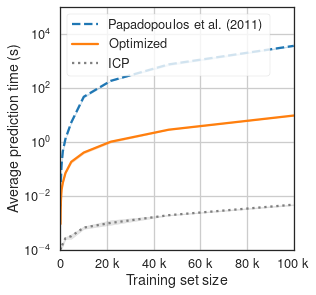

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.2))

colors = sns.color_palette()
plot_data = results
sns.lineplot(x="train_size", y="avg_time",
             data=plot_data[(plot_data.inductive_cp==False) & (plot_data.optimized==False)],
             ax=ax, legend=None, label="Papadopoulos et al. (2011)",
             color=colors[0])
sns.lineplot(x="train_size", y="avg_time",
             data=plot_data[plot_data.optimized==True],
             ax=ax, legend=None, label="Optimized",
             color=colors[1])
sns.lineplot(x="train_size", y="avg_time",
             data=plot_data[plot_data.inductive_cp==True],
             ax=ax, legend=None, label="ICP",
             color=colors[-3])
ax.lines[0].set_linestyle("--")
ax.lines[2].set_linestyle(":")

#ax.plot(range(10**5), [TIMEOUT]*10**5, color='0.30', ls=':')
ax.set_yscale("log")
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.grid()
ax.set_xlim([0, 10**5])
ax.set_ylim([10**-4, 10**5])
ax.set_xlabel("Training set size")
ax.set_ylabel("Average prediction time (s)")
ax.legend(title="", loc="upper left", frameon=True) #, labels=["Standard", "Optimized"])

plt.tight_layout()
plt.savefig(f"regression-comparison.pdf", dpi=DPI)

### Numbers

Numbers reported in the text.

In [ ]:
print("CP k-NN optimized avg pred (100k): {} seconds".format(
            results[(results.optimized==True) &
                    (results.train_size==100000) &
                    (results.inductive_cp==False)].avg_time.mean()))
print("CP k-NN avg pred (100k): {} hours".format(
            results[(results.optimized==False) &
                    (results.train_size==100000) &
                    (results.inductive_cp==False)].avg_time.mean()/60/60))
print("ICP k-NN avg pred (100k): {} seconds".format(
            results[(results.optimized==False) &
                    (results.train_size==100000) &
                    (results.inductive_cp==True)].avg_time.mean()))

# Bootstrap calculations

We estimate empirically the value $E[B']$.

In [ ]:
from itertools import count

def count_bprime(B, n):
    data_idx = list(range(n))
    E = {i: 0 for i in data_idx}
    
    for bprime in count():
        Zb = resample(data_idx)
        sampled = set(Zb)
        to_check = list(E.keys())  # Necessary to prevent issues in iterating dict.
        for i in to_check:
            if not i in sampled:
                # Bootstrap sample Zb can be used for example i.
                E[i] += 1
                # To speed up B' estimation, remove E[i] when full.
                if E[i] == B:
                    del E[i]

        # Check if all are satisfied.
        if not E:
            break
    
    return bprime

In [ ]:
REPETITIONS = 10

results = defaultdict(list)

for b in [2, 5, 10, 20, 50, 100]:
    for n in [100, 1000, 10000, 100000]:
        for seed in range(REPETITIONS):
            results["seed"].append(seed)
            results["B"].append(b)
            results["n"].append(n)
            results["B'"].append(count_bprime(b, n))

results = pd.DataFrame(results)
results.to_csv("results/bootstrap-bprime.csv")
results.head()

Producing **Figure 4**.

In [ ]:
results = pd.read_csv("results/bootstrap-bprime.csv")
plt.figure(figsize=(4.5, 4.2))
sns.lineplot("B", "B'", data=results, hue="n", legend="full")
plt.grid()
plt.xlim([0, results.B.max()])
plt.ylim([0, 400])
plt.legend(loc="best", frameon=True)
plt.ylabel("B'   ", rotation=0)

plt.tight_layout()
plt.savefig("bprime.png", dpi=DPI)

The following, `bprime()`, calculates the expectation $E[B']$ exactly,
but it is computational heavy.

In [ ]:
from itertools import permutations

P = np.exp(-1)
cache = {}

def bprime(counts):
    counts = list(filter(lambda x: x != 0, counts))
    if len(counts) == 0:
        return 0
    elif len(counts) == 1:
        return counts[0]/P
    
    key = tuple(sorted(counts))
    if key in cache:
        return cache[key]

    n = len(counts)
    p2 = (1-(1-P)**n)
    e = 1
    # k is how many are subtracted.
    # k>1 (i.e., there's at least one success),
    # since p2 already accounts for the recursion
    # on bprime(counts)
    for k in range(1, n+1):
        # happens with probability:
        p1 = P**k*(1-P)**(n-k)
        # Generate all the possible movements.
        for sub in combinations(range(n), k):
            new_counts = counts.copy()
            for i in sub:
                if new_counts[i] > 0:
                    new_counts[i] -= 1
            e += p1*bprime(new_counts)
    
    e /= p2
    
    cache[key] = e

    return e


assert bprime([0, 0, 2, 0, 0, 0]) == 2/P
assert bprime([1, 1]) == (3-2*P)/(1-(1-P)**2)
assert bprime([0, 0, 1, 0, 1, 0]) == (3-2*P)/(1-(1-P)**2)
assert bprime([2, 1]) == (3 - P + bprime([1, 1])*P*(1-P))/(1-(1-P)**2)

# Comparison on MNIST

In [ ]:
from sklearn.datasets import fetch_openml

def evaluate_ncm_mnist(ncm, inductive_cp, calibration_size, timeout):
    # Discard invalid parameter sets.
    if inductive_cp and calibration_size is None:
        return
    if not inductive_cp and calibration_size is not None:
        return
    
    X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    Y = Y.astype(int)
    ntrain = 60000
    Xtrain = X[:ntrain,]
    Ytrain = Y[:ntrain]
    Xtest = X[ntrain:,]
    Ytest = Y[ntrain:]
  
    ncm_class = eval(ncm)       # eval(): Perdoname, madre, por mi vida loca :D
    ncm = ncm_class()


    if inductive_cp:
        Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtrain, Ytrain,
                                                          test_size=calibration_size)
        pvalues, times = icp_predict(Xtrain, Ytrain, Xcalib, Ycalib,
                                     Xtest, np.unique(Y), ncm, return_time=True)
    else:
        pvalues, times = cp_predict(Xtrain, Ytrain, Xtest, np.unique(Y),
                                    ncm, return_time=True, timeout=timeout)
    
    return pvalues.tolist(), times

## Experiments

In [18]:
EXPERIMENT_NAME = "mnist-comparison"
RESULTS_DIR = "results/"
REPETITIONS = 1
TIMEOUT = 60*60*48

In [ ]:
NCMs = ["KNN", "KDE", "LSSVM", "NN", "SimplifiedKNN", "RandomForest"]

eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm_mnist,
                   repetitions=REPETITIONS,
                   n_jobs=16,
                   automatic_seed=True,
                   # Parameters
                   ncm=NCMs,
                   inductive_cp=True,
                   calibration_size=0.5,
                   timeout=TIMEOUT,
                  )

In [ ]:
# We use arbitrary precision math for KDE in this case.
KDE_fast = KDE_fast_mpmath

In [ ]:
NCMs = ["KNN_fast", "KDE_fast", "LSSVM_fast", "NN_fast", "SimplifiedKNN_fast", "RandomForest_fast"]
NCMs += ["KNN", "KDE", "LSSVM", "NN", "SimplifiedKNN", "RandomForest"]

eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm_mnist,
                   repetitions=REPETITIONS,
                   n_jobs=8,
                   automatic_seed=True,
                   # Parameters
                   ncm=NCMs,
                   inductive_cp=False,
                   calibration_size=None,
                   timeout=TIMEOUT,
                  )

## Plots

In [19]:
# Load data

eli = Eli(RESULTS_DIR)
results = eli.fetch_results("mnist-comparison")

print(f"{len(results)} observations")

NAMES = {"SimplifiedKNN": "Simplified k-NN",
         "KNN": "k-NN",
         "LSSVM": "LS-SVM",
         "KDE": "KDE",
         "RandomForest": "Random Forest",
         "NN": "NN",
        }
TIMEOUT = 60*60*48


# True labels for MNIST test set.
_, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
Y = Y.astype(int)
ntrain = 60000
Ytest = Y[ntrain:]


# The data structure is a bit different from previous experiments
# (we have p-values). So we first do a bit of unpacking.
pvalues = []
prediction_time = []
training_time = []
reached_timeout = []
calibration_time = []

for row in results.results:
    pvalues.append(row[0])
    d = row[1]
    prediction_time.append(d["prediction_time"])
    training_time.append(d["training_time"])
    reached_timeout.append(d["reached_timeout"])
    c = d["calibration_time"] if "calibration_time" in d else None
    calibration_time.append(c)

results["pvalues"] = pvalues
results["prediction_time"] = prediction_time
results["training_time"] = training_time
results["reached_timeout"] = reached_timeout
results["calibration_time"] = calibration_time

average_time = lambda vec: np.concatenate((
                                [vec[0]],
                                pd.Series(vec).diff()[1:]
                            )).mean() if len(vec) else [np.inf]

results["avg_time"] = results.prediction_time.apply(average_time)

results = results[results.timeout==TIMEOUT]

results.head()

31 observations


,name,results,ncm,inductive_cp,calibration_size,timeout,repetition,git-commit,started,finished,pvalues,prediction_time,training_time,reached_timeout,calibration_time,avg_time
1,ncm=KNN_fast-inductive_cp=False-calibration_si...,"[[[1.666638889351844e-05, 1.666638889351844e-0...",KNN_fast,False,NaN,172800,0,518a84a497f6fa122d2bf10069a8122921d8062d,2021-04-13T13:11:03.763703+00:00,2021-04-13T21:06:54.802423+00:00,"[[1.666638889351844e-05, 1.666638889351844e-05...","[6.1571719700004905, 8.886775984894484, 11.710...",2057.124651,False,NaN,2.64784
2,ncm=KNN-inductive_cp=False-calibration_size=No...,"[[], {'training_time': 0.13243418373167515, 'p...",KNN,False,NaN,172800,0,6c46c2420ef1fdbeae1d5c993f72d8b84ba15223,2021-04-16T21:20:29.249526+00:00,2021-04-18T21:20:44.887870+00:00,[],[],0.132434,True,NaN,[inf]
4,ncm=KDE-inductive_cp=False-calibration_size=No...,"[[[0.011616473058782354, 0.010299828336194397,...",KDE,False,NaN,172800,0,88c0ef46a4fdee12a2715739adff119d7cd24953,2021-03-25T02:01:39.018236+00:00,2021-04-01T00:57:27.103169+00:00,"[[0.011616473058782354, 0.010299828336194397, ...",[600932.015585535],0.148963,True,NaN,600932
5,ncm=KDE_fast-inductive_cp=False-calibration_si...,"[[[0.003983266945550908, 0.01058315694738421, ...",KDE_fast,False,NaN,172800,0,518a84a497f6fa122d2bf10069a8122921d8062d,2021-04-13T13:11:03.761652+00:00,2021-04-14T19:41:26.214120+00:00,"[[0.003983266945550908, 0.01058315694738421, 0...","[8.8238184528891, 17.559826349839568, 26.27758...",4623.610986,False,NaN,10.5184
7,ncm=SimplifiedKNN-inductive_cp=False-calibrati...,"[[[0.008566523891268479, 0.008749854169097182,...",SimplifiedKNN,False,NaN,172800,0,88c0ef46a4fdee12a2715739adff119d7cd24953,2021-03-25T02:01:39.010173+00:00,2021-03-29T04:24:57.008391+00:00,"[[0.008566523891268479, 0.008749854169097182, ...",[354181.07600883796],0.150874,True,NaN,354181


### Computation time

In [72]:
def highlight_min(data, color='yellow'):
    """
    highlight the minimum in a Series or DataFrame
    """
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

def format_time(seconds):
    seconds = int(round(seconds))
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    if h > 0:
        fmt = f"{h}h {m}m"
    elif m > 0:
        fmt = f"{m}m {s}s"
    else:
        fmt = f"{s}s"
    
    return fmt

def get_times(r):
    if len(r):
        r = r.iloc[0]
        if not np.isnan(r.calibration_time):
            training_time = format_time(r.training_time+r.calibration_time)
            total_time = r.training_time+r.calibration_time
        else:
            training_time = format_time(r.training_time)
            total_time = r.training_time
        if r.prediction_time:
            prediction_time = format_time(max(r.prediction_time))
            total_time = format_time(total_time+max(r.prediction_time))
        else:
            prediction_time = [f"{format_time(TIMEOUT)}+"]
        if r.reached_timeout:
            fmt = f"{training_time}/{prediction_time}* ({len(r.prediction_time)}) ({total_time})"
        else:
            fmt = f"{training_time} + {prediction_time} ({total_time})"
    else:
        fmt = "/"
    
    return fmt

    
NCMs = ["NN", "SimplifiedKNN", "KNN", "KDE", "RandomForest"]

table_results = {"CP": [], "Optimized CP": [], "ICP": []}

for ncm in NCMs:
    t = get_times(results[((results.ncm == ncm)) &
                                 (results.inductive_cp == False)])
    table_results["CP"].append(t)

    t = get_times(results[((results.ncm == ncm + "_fast")) &
                                 (results.inductive_cp == False)])
    table_results["Optimized CP"].append(t)

    t = get_times(results[((results.ncm == ncm)) &
                                 (results.inductive_cp == True)])
    table_results["ICP"].append(t)

table = pd.DataFrame(table_results)
table.index = NCMs
table

,CP,Optimized CP,ICP
NN,0s/109h 49m* (1) (109h 49m),34m 5s + 7h 9m (7h 44m),22m 58s + 2h 38m (3h 1m)
SimplifiedKNN,0s/98h 23m* (1) (98h 23m),29s + 4h 36m (4h 36m),3m 47s + 1h 38m (1h 42m)
KNN,0s/['48h 0m+']* (0) (0.13243418373167515),34m 17s + 7h 21m (7h 55m),20m 25s + 2h 29m (2h 49m)
KDE,0s/166h 55m* (1) (166h 55m),1h 17m + 29h 13m (30h 30m),1h 30m + 6h 13m (7h 44m)
RandomForest,0s/['48h 0m+']* (0) (0.12978316098451614),48s/['48h 0m+']* (0) (47.719479077961296),21s + 1h 25m (1h 25m)


**NOTE** the experiments in the above table were run with two different ways
of setting a timeout:
- a "strict" way, which would terminate the called function after TIMEOUT
- a "relaxed" way, which would terminate after a prediction (pvalue) was computed and if the TIMEOUT had been reached.
(This was due to computational constraints.)

Consequently, some of them show computation times greater than TIMEOUT (e.g., CP KDE: 166h).

For our purposes, we cut everything after TIMEOUT (=48h), but keep these numbers here for reference.

### Prediction efficiency

We compare CP and ICP w.r.t.: fuzziness and average number of errors for a fixed significance level.

The fuzziness of a set of p-values $\{p_y\}_{y\in Y}$ is the average
of the p-values excluding the largest one:

$$\sum_{y\in Y} p_y - \max_y p_y .$$

The smaller it is, the better.

We use the Welch one-sided statistical test for the
null hypothesis $H_0$: "ICP has a smaller fuzziness (i.e., it is better) than CP".

We reject the null hypothesis for a p-value $< 0.01$.

We also evaluate the methods w.r.t. their average number of errors. This metric is however not ideal for evaluating CP classification, as it reflects a very coarse requirement.

In [73]:
def pvalues_stats(results, true_labels, eps=0.05):
    if not len(results):
        return None, None, [None], None
    pvalues = results.iloc[0].pvalues
    if not len(pvalues):
        return None, None, [None], None
    avg = np.mean(pvalues, axis=1)
    fuzziness = []
    errors = []
    avg_size = []
    for y, pvals in zip(true_labels, pvalues):
        pvals = sorted(pvals)
        fuzziness.append(np.mean(pvals[:-1]))
        e = pvals[y] > eps
        errors.append(e)
        avg_size.append(sum(np.array(pvals) > eps))
    
    return avg, fuzziness, errors, np.mean(avg_size)

def compare_cp_icp(cp, icp, quantity="fuzziness", eps=0.1, real_labels=Ytest):
    """We run a statistical test to verify if cp is better than icp
    w.r.t. the chosen quantity.
    """
    avgpval_cp, fuzziness_cp, errors_cp, avg_error_cp = pvalues_stats(cp, real_labels)
    avgpval_icp, fuzziness_icp, errors_icp, avg_error_icp = pvalues_stats(icp, real_labels)
    
    if quantity == "fuzziness":
        a, b = fuzziness_cp, fuzziness_icp
    elif quantity == "errors":
        a, b = errors_cp, errors_icp
        if a[0] is None or b[0] is None:
            a = None
            b = None
    else:
        raise Exception("not implemented")

    if a is not None and b is not None:
        n = min(len(a), len(b))
        test = ttest_ind(a[:n], b[:n], equal_var=False, alternative="less")
        pvalue = test.pvalue
        stats = np.mean(a), np.std(a), np.mean(b), np.std(b)
    else:
        pvalue = None
        stats = [None]*4
    
    return pvalue, stats

In [74]:
from scipy.stats import ttest_ind

CP_EPS = 0.1
NCMs = ["NN", "SimplifiedKNN", "KNN", "KDE"]

table_results = {"CP-fuzziness": [], "ICP-fuzziness": [], "Fuzziness Welch's test p-value": [],
                 "CP-errors": [], "ICP-errors": [], "Errors Welch's test p-value": []}


for ncm in NCMs:
    pvalue, (fuz_mean_cp, fuz_std_cp, fuz_mean_icp, fuz_std_icp) = \
        compare_cp_icp(results[((results.ncm == ncm + "_fast")) & (results.inductive_cp == False)],
                       results[((results.ncm == ncm)) & (results.inductive_cp == True)],
                       quantity="fuzziness", eps=CP_EPS, real_labels=Ytest)
    
    table_results["CP-fuzziness"].append(f"{fuz_mean_cp} \pm {fuz_std_cp}")
    table_results["ICP-fuzziness"].append(f"{fuz_mean_icp} \pm {fuz_std_icp}")
    table_results["Fuzziness Welch's test p-value"].append(pvalue)
    
    pvalue, (err_mean_cp, err_std_cp, err_mean_icp, err_std_icp) = \
        compare_cp_icp(results[((results.ncm == ncm + "_fast")) & (results.inductive_cp == False)],
                       results[((results.ncm == ncm)) & (results.inductive_cp == True)],
                       quantity="errors", eps=CP_EPS, real_labels=Ytest)
    
    table_results["CP-errors"].append(f"{err_mean_cp} \pm {err_std_cp}")
    table_results["ICP-errors"].append(f"{err_mean_icp} \pm {err_std_icp}")
    table_results["Errors Welch's test p-value"].append(pvalue)

    

table = pd.DataFrame(table_results)
table.index = NCMs
table

,CP-fuzziness,ICP-fuzziness,Fuzziness Welch's test p-value,CP-errors,ICP-errors,Errors Welch's test p-value
NN,0.00047120788727595287 \pm 0.001053153206224986,0.0006458762485694922 \pm 0.0014301424366343868,4.571809e-23,0.0946 \pm 0.2926616476410942,0.097 \pm 0.29595776725742473,2.821133e-01
SimplifiedKNN,0.04998261343792418 \pm 0.07151025197073532,0.056842360439837196 \pm 0.07743769360518381,3.908227e-11,0.3196 \pm 0.4663216057615173,0.3574 \pm 0.4792340138178843,8.004115e-09
KNN,0.0006636913458849759 \pm 0.0012478295179766522,0.0009820046739182767 \pm 0.0017408069323029127,5.794395e-50,0.0965 \pm 0.2952757186088961,0.0983 \pm 0.29771985153832115,3.338728e-01
KDE,0.04250649711393699 \pm 0.06775728672896837,0.16791270661348326 \pm 0.11729239544234434,0.000000e+00,0.2612 \pm 0.4392886977831321,0.427 \pm 0.494642294997102,8.961766e-137
